In [8]:
#Importing the libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os
import dotenv
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")


In [9]:
#Creating the credentials for the Spotify API
dotenv.load_dotenv()
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [10]:
#Reading the data
data = pd.read_csv(r'files\track_data.csv')
billboard = pd.read_csv(r'files\billboard_hot_100.csv')
features = pd.read_csv(r'files\tracks_features.csv')

In [11]:
features.dtypes

id                   object
name                 object
album                object
album_id             object
artists              object
artist_ids           object
track_number          int64
disc_number           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature      float64
year                  int64
release_date         object
dtype: object

In [12]:
features = features.drop(columns=['disc_number', 'track_number', 'year'])

In [13]:
#Creating a function to check if a song is in the billboard hot 100 dataset
def check_billboard(song):
    if song in billboard['Song'].values:
        return True
    else:
        return False

In [14]:
#Creating a function to get the song features from Spotify
def get_song_features(song):
    try:
        results = sp.search(q='track:'+song, type='track')
        song_id = results['tracks']['items'][0]['id']
        features = sp.audio_features(song_id)
        return features[0]
    except:
        return None

In [15]:
cluster_data = features.select_dtypes(include=[np.number])

In [16]:
#Scaling the data
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

In [17]:
#Checking the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(cluster_data_scaled)
    wcss.append(kmeans.inertia_)

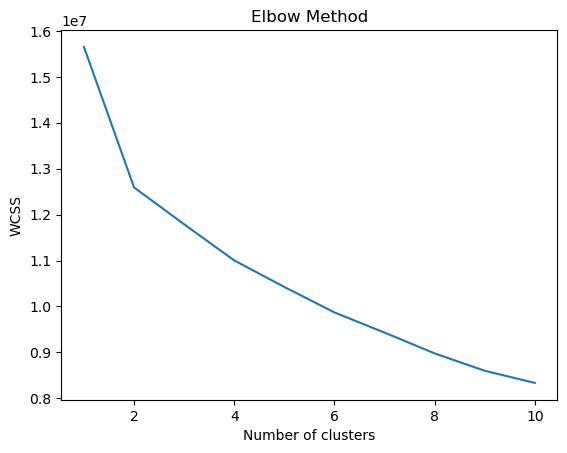

In [18]:
#Plotting the elbow method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

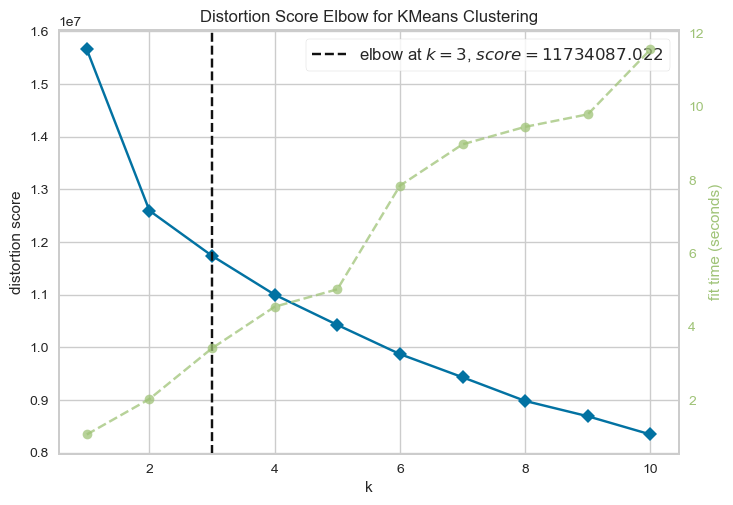

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
#Plotting using Yellowbrick
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(cluster_data_scaled)
visualizer.show()

In [20]:
#From the plots we can see that the optimal number of clusters is 2, but for song recomenddation, I think it will be better to have more clusters and variety
#So I will use 3 clusters
kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(cluster_data_scaled)
features['cluster'] = kmeans.labels_

In [21]:
features['cluster'].value_counts()

cluster
1    249782
7    221719
3    212917
5    210519
0    176643
4     70921
6     40157
2     21367
Name: count, dtype: int64

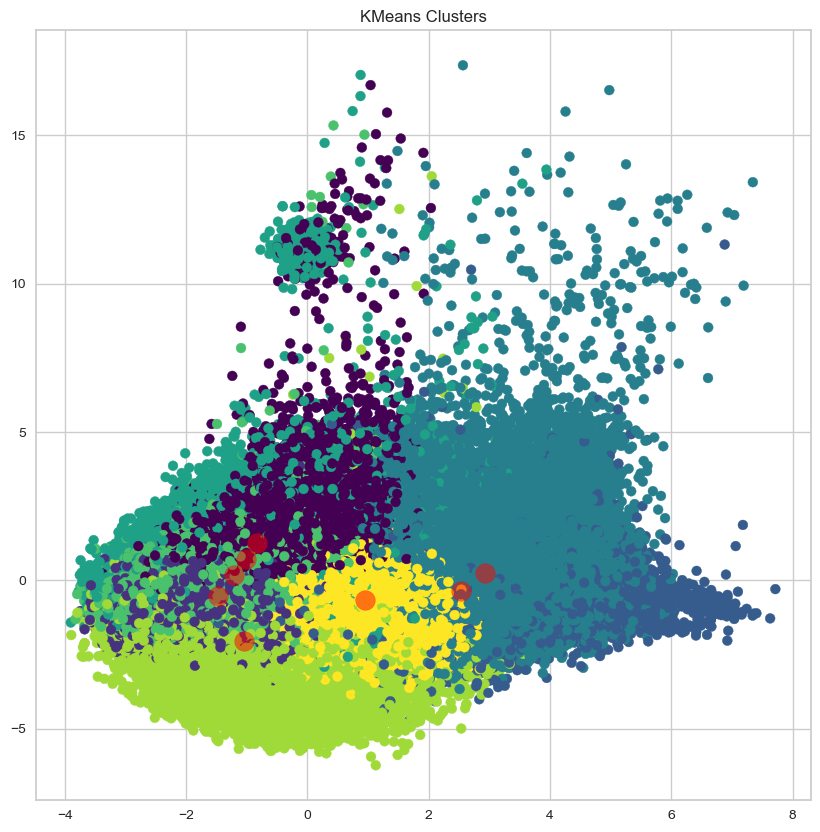

In [22]:
#Plotting the clusters and its centroids
pca = PCA(n_components=2)
pca_data = pca.fit_transform(cluster_data_scaled)
pca_centers = pca.transform(kmeans.cluster_centers_)
plt.figure(figsize=(10, 10))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', s=200, alpha=0.5)
plt.title('KMeans Clusters')
plt.show()

In [23]:
#Trying to cluster the data using DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)
dbscan.fit(cluster_data_scaled)
features['cluster_dbscan'] = dbscan.labels_

features['cluster_dbscan'].value_counts()

cluster_dbscan
-1        771605
 0        190092
 2         34353
 112        7181
 8          6783
           ...  
 29221         2
 29222         2
 29223         2
 29225         2
 69642         2
Name: count, Length: 69644, dtype: int64

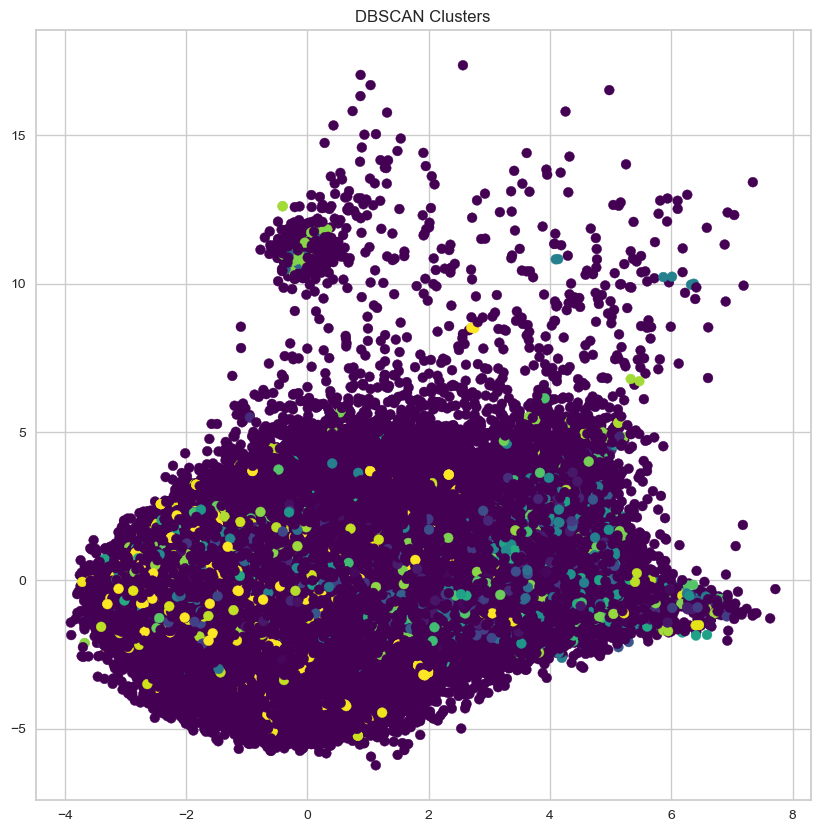

In [24]:
#Plotting the clusters
plt.figure(figsize=(10, 10))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=dbscan.labels_, s=50, cmap='viridis')
plt.title('DBSCAN Clusters')
plt.show()

In [25]:
#Trying to cluster the data using Gaussian Mixture
gmm = GaussianMixture(n_components=3)
gmm.fit(cluster_data_scaled)
features['cluster_gmm'] = gmm.predict(cluster_data_scaled)

features['cluster_gmm'].value_counts()

cluster_gmm
1    928255
2    154742
0    121028
Name: count, dtype: int64

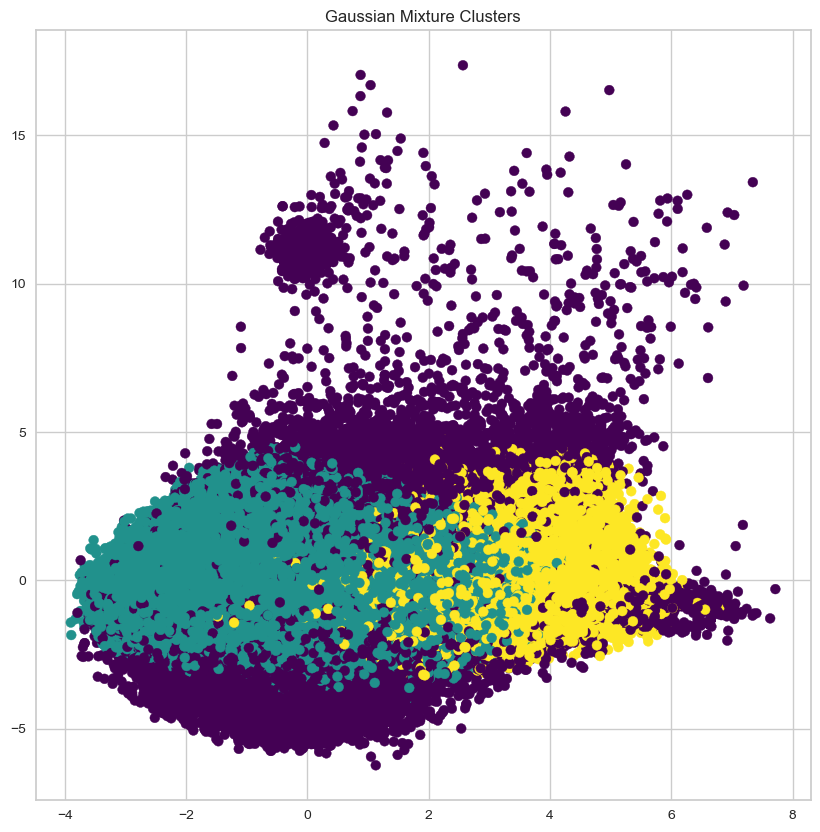

In [26]:
#Plotting the clusters and its centroids
plt.figure(figsize=(10, 10))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=gmm.predict(cluster_data_scaled), s=50, cmap='viridis')
plt.title('Gaussian Mixture Clusters')
plt.show()

The cluster distribution id better with kmeans, so we will stick to it

In [27]:
#Dropping the clusters that we will not use
features = features.drop(['cluster_dbscan', 'cluster_gmm'], axis=1)

In [28]:
#Creating a function to search for a song in the dataframe and return the cluster
def get_cluster(song):
    try:
        return features[features['name'] == song]['cluster'].values[0]
    except:
        return None

In [29]:
#Testing the function
search_song('Shape of You')

5